In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vgg-file/vgg19-dcbb9e9d.pth
/kaggle/input/images/style imge.jpg
/kaggle/input/images/conten image.jpg
/kaggle/input/no-mawn/con3.jpg
/kaggle/input/no-mawn/sty2.jpg
/kaggle/input/content/contentIMG2.jpg


In [37]:
#importing all required libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import copy


In [51]:
def image_loader(image_path, imsize, device):
    loader = transforms.Compose([
        transforms.Resize((imsize, imsize)),  # Ensure both width and height = imsize
        transforms.CenterCrop(imsize),        # Optional: Ensure square shape
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [80]:
# display the images
display=transforms.ToPILImage()
def imshow(tensor,title=None):
    image=tensor.cpu().clone()
    image=image.squeeze(0)
    image=display(image)
    if title is not None:
        plt.title(title)
    plt.imshow(image)
        

In [55]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [56]:
#loading pretrained model to extract features 
# Step 1: Load the VGG19 architecture
vgg = models.vgg19()
vgg.load_state_dict(torch.load("/kaggle/input/vgg-file/vgg19-dcbb9e9d.pth"))

# Extract feature layers and move model to device
cnn = vgg.features.to(device).eval()



In [57]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)
    def forward(self, img):
        return (img - self.mean) / self.std


In [58]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                style_img, content_img,
                                content_layers=['conv_4'],
                                style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):

    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')
        
        model.add_module(name, layer)
        
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim model after last loss
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]

    return model, style_losses, content_losses


In [59]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


In [65]:
def style_transfer(cnn, normalization_mean, normalization_std,
                   content_img, style_img, input_img,
                   num_steps=100, style_weight=1e5, content_weight=10):

    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img)

    optimizer = get_input_optimizer(input_img)
    run = [0]
    
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
                
            loss = style_weight * style_score + content_weight * content_score
            loss.backward()
            
            run[0] += 1
            if run[0] % 25 == 0:
                print(f"Step {run[0]} - Style Loss: {style_score.item():.4f} | Content Loss: {content_score.item():.4f}")
            
            return loss
        optimizer.step(closure)
    
    input_img.data.clamp_(0, 1)
    return input_img


In [61]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


In [75]:
con='/kaggle/input/no-mawn/con3.jpg'
st='/kaggle/input/no-mawn/sty2.jpg'
st1='/kaggle/input/images/style imge.jpg'

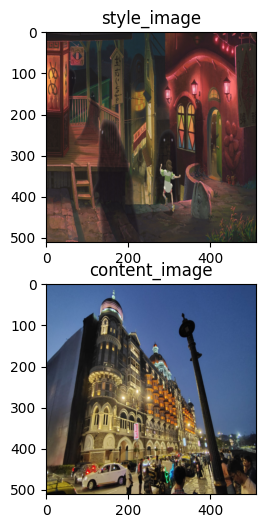

Step 25 - Style Loss: 0.0002 | Content Loss: 1.9044
Step 50 - Style Loss: 0.0001 | Content Loss: 1.5354
Step 75 - Style Loss: 0.0001 | Content Loss: 1.4588
Step 100 - Style Loss: 0.0001 | Content Loss: 1.4193


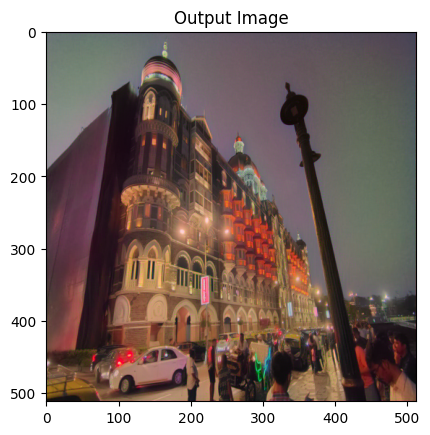

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 512  # Smaller if no GPU

# Upload and load images
style_img = image_loader(st1, imsize, device)
content_img = image_loader(con, imsize, device)
#ploting both images 
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
imshow(style_img,title='style_image')
plt.subplot(2,1,2)
imshow(content_img,title='content_image')
plt.show()
assert style_img.size() == content_img.size(), "Images must be the same size!"

# Initial image
input_img = content_img.clone()

# Pretrained VGG
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Run Style Transfer
output = style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                        content_img, style_img, input_img, num_steps=100)

# Show Output
imshow(output, title='Output Image')
